# <font color='red' size='6'>Inteligência Artificial</font>
#### CNN com PyTorch
#### Dataset:  dataset

In [15]:
import torch
import torchvision
import torchvision.transforms as transforms
from torchvision import models
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import os

In [ ]:
# Verifica GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Usando dispositivo:", device)

Usando dispositivo: cpu


In [17]:
# Caminho para dataset dividido em pastas (ex: 'dataset_tf_flowers/train', 'val', 'test')
data_dir = "dataset"
batch_size = 32

In [18]:
# Transforms
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Redimensionando para 224x224
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor() # Convertendo as imagens para tensor
]) 
test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

In [19]:
# Datasets
train_dataset = torchvision.datasets.ImageFolder(os.path.join(data_dir, "train"), transform=train_transform)
val_dataset = torchvision.datasets.ImageFolder(os.path.join(data_dir, "validation"), transform=test_transform)
test_dataset = torchvision.datasets.ImageFolder(os.path.join(data_dir, "test"), transform=test_transform)

In [20]:
# Loaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [21]:
import torchvision.models as models
from torchvision.models import ResNet18_Weights

In [22]:
# Modelo base
model = models.resnet18(weights=ResNet18_Weights.DEFAULT)
for param in model.parameters():
    param.requires_grad = False
model.fc = torch.nn.Linear(model.fc.in_features, 4)  # Changed from 5 to 4
model = model.to(device)

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.fc.parameters(), lr=0.001)

In [ ]:
# Treinamento - Feature Extraction
train_losses, val_losses = [], []
train_accs, val_accs = [], []

for epoch in range(50):
    model.train()  # Coloca o modelo em modo de treinamento
    total_loss, correct = 0, 0
    for x, y in train_loader:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        out = model(x)
        loss = criterion(out, y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()  # Acumula a perda do treinamento
        correct += (out.argmax(1) == y).sum().item()  # Conta o número de acertos

    train_loss = total_loss / len(train_loader)
    train_acc = correct / len(train_dataset)  # Acurácia de treinamento
    train_losses.append(train_loss)
    train_accs.append(train_acc)

    # Imprime a perda e a acurácia de treino a cada época
    print(f"Epoch {epoch+1}/{50} - Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.4f}")

    model.eval()  # Coloca o modelo em modo de avaliação
    correct, total_val_loss = 0, 0
    with torch.no_grad():  # Desabilita o cálculo do gradiente para validação
        for x, y in val_loader:
            x, y = x.to(device), y.to(device)
            out = model(x)
            loss = criterion(out, y)
            total_val_loss += loss.item()  # Acumula a perda de validação
            correct += (out.argmax(1) == y).sum().item()  # Conta o número de acertos de validação

    val_loss = total_val_loss / len(val_loader)
    val_acc = correct / len(val_dataset)  # Acurácia de validação
    val_losses.append(val_loss)
    val_accs.append(val_acc)

    # Imprime a perda e a acurácia de validação a cada época
    print(f"Epoch {epoch+1}/{25} - Val Loss: {val_loss:.4f}, Val Accuracy: {val_acc:.4f}")

Epoch 1/25 - Train Loss: 0.9751, Train Accuracy: 0.6202
Epoch 1/25 - Val Loss: 0.6547, Val Accuracy: 0.8000
Epoch 1/25 - Val Loss: 0.6547, Val Accuracy: 0.8000
Epoch 2/25 - Train Loss: 0.6362, Train Accuracy: 0.7863
Epoch 2/25 - Train Loss: 0.6362, Train Accuracy: 0.7863
Epoch 2/25 - Val Loss: 0.5138, Val Accuracy: 0.8300
Epoch 2/25 - Val Loss: 0.5138, Val Accuracy: 0.8300
Epoch 3/25 - Train Loss: 0.5381, Train Accuracy: 0.8039
Epoch 3/25 - Train Loss: 0.5381, Train Accuracy: 0.8039
Epoch 3/25 - Val Loss: 0.4507, Val Accuracy: 0.8514
Epoch 3/25 - Val Loss: 0.4507, Val Accuracy: 0.8514
Epoch 4/25 - Train Loss: 0.4804, Train Accuracy: 0.8268
Epoch 4/25 - Train Loss: 0.4804, Train Accuracy: 0.8268
Epoch 4/25 - Val Loss: 0.3997, Val Accuracy: 0.8643
Epoch 4/25 - Val Loss: 0.3997, Val Accuracy: 0.8643
Epoch 5/25 - Train Loss: 0.4538, Train Accuracy: 0.8321
Epoch 5/25 - Train Loss: 0.4538, Train Accuracy: 0.8321
Epoch 5/25 - Val Loss: 0.3863, Val Accuracy: 0.8557
Epoch 5/25 - Val Loss: 0.386

In [ ]:
# Fine-tuning - libera todos os parâmetros
for param in model.parameters():
    param.requires_grad = True

optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

# Inicializa listas para armazenar o loss e a acurácia
train_losses = []
train_accs = []

for epoch in range(50):
    model.train()  # Coloca o modelo em modo de treinamento
    total_loss, correct = 0, 0
    total_samples = 0  # Contador para o número total de amostras

    for x, y in train_loader:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()  # Zera o gradiente do otimizador
        out = model(x)  # Faz a previsão com o modelo
        loss = criterion(out, y)  # Calcula o loss
        loss.backward()  # Calcula os gradientes
        optimizer.step()  # Atualiza os parâmetros do modelo

        total_loss += loss.item()  # Acumula a perda
        correct += (out.argmax(1) == y).sum().item()  # Conta o número de acertos
        total_samples += y.size(0)  # Contabiliza o número de amostras

    # Calcula o loss e a acurácia para a época
    epoch_loss = total_loss / len(train_loader)
    epoch_acc = correct / total_samples

    # Armazena os valores do loss e acurácia
    train_losses.append(epoch_loss)
    train_accs.append(epoch_acc)

    # Imprime o loss e a acurácia de treinamento a cada época
    print(f"Epoch {epoch+1}/{50} - Train Loss: {epoch_loss:.4f}, Train Accuracy: {epoch_acc:.4f}")

Epoch 1/50 - Train Loss: 0.3959, Train Accuracy: 0.8540
Epoch 2/50 - Train Loss: 0.2589, Train Accuracy: 0.9117
Epoch 2/50 - Train Loss: 0.2589, Train Accuracy: 0.9117
Epoch 3/50 - Train Loss: 0.1811, Train Accuracy: 0.9375
Epoch 3/50 - Train Loss: 0.1811, Train Accuracy: 0.9375
Epoch 4/50 - Train Loss: 0.1519, Train Accuracy: 0.9480
Epoch 4/50 - Train Loss: 0.1519, Train Accuracy: 0.9480
Epoch 5/50 - Train Loss: 0.1148, Train Accuracy: 0.9618
Epoch 5/50 - Train Loss: 0.1148, Train Accuracy: 0.9618
Epoch 6/50 - Train Loss: 0.1390, Train Accuracy: 0.9542
Epoch 6/50 - Train Loss: 0.1390, Train Accuracy: 0.9542
Epoch 7/50 - Train Loss: 0.1159, Train Accuracy: 0.9599
Epoch 7/50 - Train Loss: 0.1159, Train Accuracy: 0.9599
Epoch 8/50 - Train Loss: 0.1011, Train Accuracy: 0.9647
Epoch 8/50 - Train Loss: 0.1011, Train Accuracy: 0.9647
Epoch 9/50 - Train Loss: 0.0958, Train Accuracy: 0.9599
Epoch 9/50 - Train Loss: 0.0958, Train Accuracy: 0.9599
Epoch 10/50 - Train Loss: 0.0780, Train Accuracy

In [11]:
# Avaliação no conjunto de teste
model.eval()
correct = 0
test_loss = 0
y_true, y_pred = [], []
with torch.no_grad():
    for x, y in test_loader:
        x, y = x.to(device), y.to(device)
        out = model(x)
        loss = criterion(out, y)
        test_loss += loss.item()
        correct += (out.argmax(1) == y).sum().item()
        y_true.extend(y.cpu().numpy())
        y_pred.extend(out.argmax(1).cpu().numpy())

test_loss /= len(test_loader)
test_acc = correct / len(test_dataset)
print(f"Acurácia no teste: {test_acc:.4f}")

Acurácia no teste: 0.9084


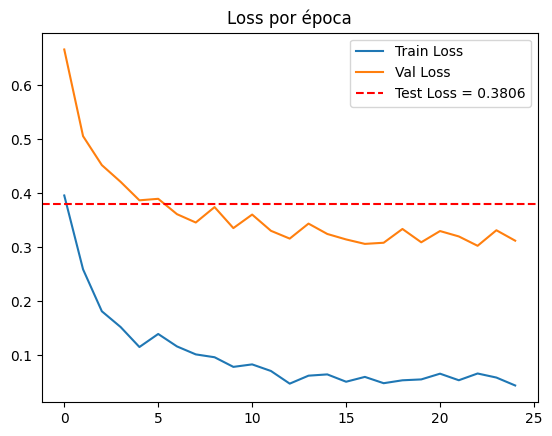

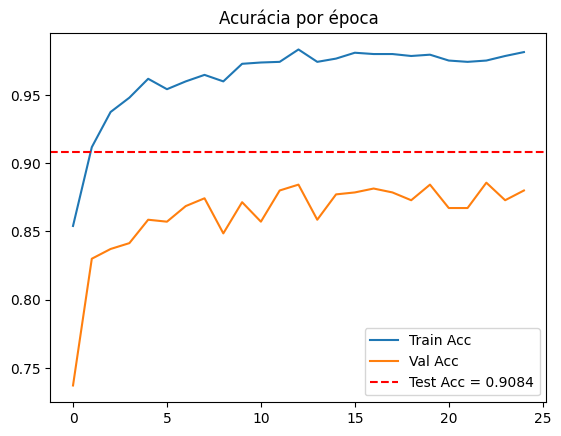

In [12]:
# Gráficos
plt.figure()
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.axhline(y=test_loss, color='r', linestyle='--', label=f"Test Loss = {test_loss:.4f}")
plt.legend()
plt.title("Loss por época")
plt.show()

plt.figure()
plt.plot(train_accs, label='Train Acc')
plt.plot(val_accs, label='Val Acc')
plt.axhline(y=test_acc, color='r', linestyle='--', label=f"Test Acc = {test_acc:.4f}")
plt.legend()
plt.title("Acurácia por época")
plt.show()

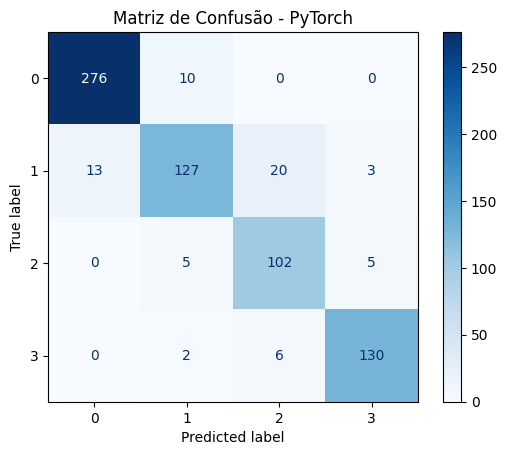

In [13]:
# Matriz de confusão
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title("Matriz de Confusão - PyTorch")
plt.show()

In [14]:
# Salvando o modelo
model_path = "resnet18_model.pth"
torch.save(model.state_dict(), model_path)
print(f"Modelo salvo em {model_path}")

Modelo salvo em resnet18_model.pth
